In [175]:
import linopy
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

## First battery arbitrage example

- Read the load file
- Assign a cost per kW for battery and time-varying cost for load
- Minimize the cost, record the battery power.
- Plot

### Loading load profile

In [176]:
load = pd.read_csv('Test_load.csv', delimiter = ';')[3:] #assign the csv file to the dataframe and disregard the first 3 row
load = load.reset_index(drop=True)                              #re-assign the index value
load.columns = ['Date','Power']                          #rename the columns
load["Date"]=pd.date_range("01/01/2022 00:00", periods=8760, freq='h') #to put the values in an according date time
load["Power"]=pd.to_numeric(load.Power)                  #convert the power values into float
load = load.fillna(0)

testmonth_load =load.loc[(load['Date'].dt.month==1)] #select January as test month

index = list(testmonth_load.index.values)    #assign a list for variable, each index is a variable namepd.renameload.columns[1] = "Load"



    

### Modeling Cost

In [177]:

#-------Adding a time varying tariff-----------
testmonth_load['Tariff'] = [0.14 if (12 <= time.hour <=18)   else
                     0.1 if ( (8<= time.hour <= 12) | (18 <= time.hour <= 22))  else
                     0.08 for time in testmonth_load['Date']]
#-------for simplicity only; in the future the tariff should be mapped from another dataframe
                             
BattCost = 314.2                          #per KWH
InverterCost = 65.6                       #per KW
BatteryCapacity = 200                     #kWh


/tmp/ipykernel_2889370/3144992809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testmonth_load['Tariff'] = [0.14 if (12 <= time.hour <=18)   else


In [178]:
i= testmonth_load['Date'].values
#--------Linopy implementation---------------------
model = linopy.Model()
#set the bounds for battery power
ub = max(load['Power'])
lb = -ub

#set parameters
cost = testmonth_load['Tariff'].to_xarray()
load_value = testmonth_load['Power'].to_xarray()
load_value


/usr/local/lib/python3.11/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<xarray.DataArray 'Power' (index: 744)>
array([216.5808449, 216.5808449, 216.5808449, 216.5808449, 216.5808449,
       203.5898294, 203.5898294, 115.2698294, 405.5859709, 405.5859709,
       439.3282344, 439.3282344, 442.2909265, 447.567648 , 447.567648 ,
       447.567648 , 447.567648 , 480.1465367, 277.8340784, 277.8340784,
       277.8340784, 277.8340784, 277.8340784, 216.5808449, 216.5808449,
       216.5808449, 216.5808449, 216.5808449, 216.5808449, 203.5898294,
       203.5898294, 115.2698294, 405.5859709, 405.5859709, 439.3282344,
       439.3282344, 442.2909265, 447.567648 , 447.567648 , 447.567648 ,
       447.567648 , 480.1465367, 277.8340784, 277.8340784, 277.8340784,
       277.8340784, 277.8340784, 216.5808449, 216.5808449, 216.5808449,
       216.5808449, 216.5808449, 216.5808449, 203.5898294, 203.5898294,
       115.2698294, 405.5859709, 405.5859709, 439.3282344, 439.3282344,
       442.2909265, 447.567648 , 447.567648 , 447.567648 , 447.567648 ,
       480.1465367, 277.8340784, 277.8340784, 277.8340784, 277.8340784,
       277.8340784, 216.5808449, 216.5808449, 216.5808449, 216.5808449,
       216.5808449, 216.5808449, 203.5898294, 203.5898294, 115.2698294,
       405.5859709, 405.5859709, 439.3282344, 439.3282344, 442.2909265,
       447.567648 , 447.567648 , 447.567648 , 447.567648 , 480.1465367,
       277.8340784, 277.8340784, 277.8340784, 277.8340784, 277.8340784,
       216.5808449, 216.5808449, 216.5808449, 216.5808449, 216.5808449,
...
       277.8340784, 277.8340784, 216.5808449, 216.5808449, 216.5808449,
       216.5808449, 216.5808449, 216.5808449, 203.5898294, 203.5898294,
       115.2698294, 405.5859709, 405.5859709, 439.3282344, 439.3282344,
       442.2909265, 447.567648 , 447.567648 , 447.567648 , 447.567648 ,
       480.1465367, 277.8340784, 277.8340784, 277.8340784, 277.8340784,
       277.8340784, 216.5808449, 216.5808449, 216.5808449, 216.5808449,
       216.5808449, 216.5808449, 203.5898294, 203.5898294, 115.2698294,
       405.5859709, 405.5859709, 439.3282344, 439.3282344, 442.2909265,
       447.567648 , 447.567648 , 447.567648 , 447.567648 , 480.1465367,
       277.8340784, 277.8340784, 277.8340784, 277.8340784, 277.8340784,
       216.5808449, 216.5808449, 216.5808449, 216.5808449, 216.5808449,
       216.5808449, 203.5898294, 203.5898294, 115.2698294, 405.5859709,
       405.5859709, 439.3282344, 439.3282344, 442.2909265, 447.567648 ,
       447.567648 , 447.567648 , 447.567648 , 480.1465367, 277.8340784,
       277.8340784, 277.8340784, 277.8340784, 277.8340784, 216.5808449,
       216.5808449, 216.5808449, 216.5808449, 216.5808449, 216.5808449,
       203.5898294, 203.5898294, 115.2698294, 405.5859709, 405.5859709,
       439.3282344, 439.3282344, 442.2909265, 447.567648 , 447.567648 ,
       447.567648 , 447.567648 , 480.1465367, 277.8340784, 277.8340784,
       277.8340784, 277.8340784, 277.8340784, 216.5808449])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 736 737 738 739 740 741 742 743

In [179]:
#set variables
Pbatt = model.add_variables(lower=lb, upper= ub, coords=cost.coords, name="Pbatt" ) #linopy
Pbatt

Variable (index: 744)
---------------------
[0]: Pbatt[0] ∈ [-1766, 1766]
[1]: Pbatt[1] ∈ [-1766, 1766]
[2]: Pbatt[2] ∈ [-1766, 1766]
[3]: Pbatt[3] ∈ [-1766, 1766]
[4]: Pbatt[4] ∈ [-1766, 1766]
[5]: Pbatt[5] ∈ [-1766, 1766]
[6]: Pbatt[6] ∈ [-1766, 1766]
		...
[737]: Pbatt[737] ∈ [-1766, 1766]
[738]: Pbatt[738] ∈ [-1766, 1766]
[739]: Pbatt[739] ∈ [-1766, 1766]
[740]: Pbatt[740] ∈ [-1766, 1766]
[741]: Pbatt[741] ∈ [-1766, 1766]
[742]: Pbatt[742] ∈ [-1766, 1766]
[743]: Pbatt[743] ∈ [-1766, 1766]

In [180]:
#a = (Pbatt + load_value)*cost
a = Pbatt*cost
obj=a.sum()

In [181]:
Pbatt.indexes

Indexes:
    index    Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       734, 735, 736, 737, 738, 739, 740, 741, 742, 743],
      dtype='int64', name='index', length=744)

In [182]:
lim=Pbatt.rolling(index=744).sum()
Battcapp=pd.Series(0.8*BatteryCapacity, index=cost.index).to_xarray()
#rint(lim
expr0=lim <=0
expr1=(lim + 0.8*BatteryCapacity )>=0


/usr/local/lib/python3.11/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/usr/local/li

### Optimization model

In [183]:


#set objective


#cost_function =  (load_value + Pbatt)*cost 

                     
#set constraints#     
load_con1= model.add_constraints(Pbatt - load_value <=0, name="Battery power cannot be higher than load" )
load_con2= model.add_constraints(Pbatt + load_value <=ub, name="New load profile + battery power cannot excess the highest load")
Qmax_con = model.add_constraints(expr0, name="Qmax constraint")
Qmin_con = model.add_constraints(expr1, name="Qmin constraint")
Pmax_con1 = model.add_constraints(Pbatt <= 50, name="4h Battery charge")
Pmax_con2 = model.add_constraints(Pbatt >= -50, name="4h Battery discharge")
model.add_objective(obj)

/usr/local/lib/python3.11/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/usr/local/li

In [184]:
model.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1486 rows, 744 cols, 554278 nonzeros
742 rows, 743 cols, 276395 nonzeros
738 rows, 739 cols, 273429 nonzeros
Presolve : Reductions: rows 738(-3726); columns 739(-5); elements 273429(-283827)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        469    -3.1040000000e+02 Pr: 0(0); Du: 0(5.27356e-16) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 469
Objective value     : -3.1040000000e+02
HiGHS run time      :          0.90


('ok', 'optimal')

<AxesSubplot: xlabel='index', ylabel='Optimal Value'>

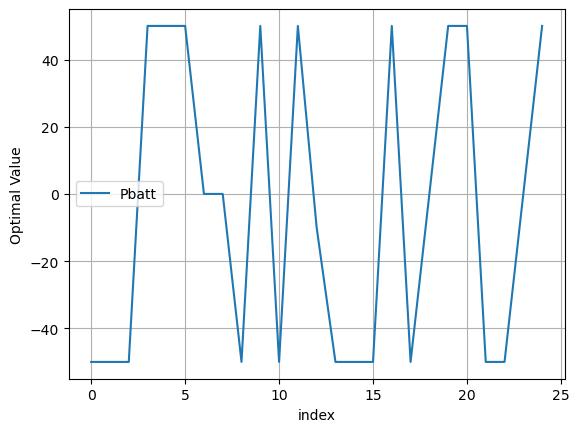

In [185]:
model.solution.to_dataframe().loc[:24].plot(grid=True, ylabel='Optimal Value')

In [186]:
#Pmax_con= model.add_constraints()
#Pmin_con= model.add_constraints()

model.Constraint = pyo.ConstraintList()
for i in index:
    print(load_value[i])
    model.Constraint.add( expr = model.Pbatt[i] - load_value[i] <= 0) #load constraint
    model.Constraint.add( expr = model.Pbatt[i] - model.Pmax  <= 0 ) #Pmax constraint
    model.Constraint.add( expr = model.Pbatt[i] + model.Pmax  >= 0 )#Pmin constraint
    model.Constraint.add( expr = model.Pbatt[i] + load_value[i] <= ub )#Total load constraint

 #   model.Constraint.add( expr = model.Pbatt[i] - model.Qmax <= 0 )#Qmax constraint
#  model.Constraint.add( expr = model.Pbatt[i] + model.Qmax >= 0 )#Qmax constraint

    model.Constraint.add( expr = model.Qmax + sum([model.Pbatt[j]*1 for j in range(i)]) - model.Qmax <= 0 )#Qmax constraint
    model.Constraint.add( expr = model.Qmax + sum([model.Pbatt[j]*1 for j in range(i)]) - 0.2*model.Qmax >= 0) #Qmin constraint
    
#print the model
#model.pprint()

NameError: name 'pyo' is not defined

# Simple test model

In [ ]:
m = linopy.Model()

time = pd.Index(range(10), name='time')
#x = m.add_variables(lower=0, coords=[time], name='x', )
#y = m.add_variables(lower=0, coords=[time], name='y')
Pbatt = m.add_variables(lower=lb, upper= ub, coords=cost.coords, name="Pbatt" ) #linopy

#factor = pd.Series(time, index=time)
#3*x + 7*y >= 10*factor

#con1 = m.add_constraints(3*x + 7*y >= 10*factor, name='con1')
#con2 = m.add_constraints(5*x + 2*y >= 3*factor, name='con2')
a = (Pbatt + load_value)*cost
obj=a.sum()
#obj = (x + 2*y).sum()
#m.add_objective(obj)
a

In [ ]:
m1 = linopy.Model()

x = m1.add_variables(lower=0, coords=[time], name='x', )
y = m1.add_variables(lower=0, coords=[time], name='y')
a= x+2*y+5
obj = (a).sum()
m1.add_objective(obj)


In [ ]:
m

In [ ]:
m.solve()


In [ ]:
m.solution.to_dataframe().plot(grid=True, ylabel='Optimal Value')
